In [1]:
# The code below ignores warnings generated from certain cells
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# 1. Data Exploration

In [3]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='ISO-8859-1', \
                 dtype = {'InvoiceNo' : str, 'StockCode' : str, 'Description' : str, 'Quantity' : int,
                                   'UnitPrice' : float, 'CustomerID' : str, 'Country' : str})

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [5]:
#Data Overviews Function
def sum_info(df):
    print("Number of rows: {0}, number of columns: {1}".format(df.shape[0], df.shape[1]))
    info = pd.DataFrame(df.dtypes, columns=['dtypes'])
    info = info.reset_index()
    info['Name'] = info['index']
    info = info[['Name', 'dtypes']]
    info['Missing'] = df.isnull().sum().values
    info['Missing_%'] = info['Missing']/df.shape[0]*100
    info['Uniques'] = df.nunique().values
    info['First Row'] = df.loc[0].values
    info['Last Row'] = df.loc[df.shape[0]-1].values

    return info

In [6]:
sum_info(df)

Number of rows: 541909, number of columns: 8


,Name,dtypes,Missing,Missing_%,Uniques,First Row,Last Row
0,InvoiceNo,object,0,0.000000,25900,536365,581587
1,StockCode,object,0,0.000000,4070,85123A,22138
2,Description,object,1454,0.268311,4223,WHITE HANGING HEART T-LIGHT HOLDER,BAKING SET 9 PIECE RETROSPOT
3,Quantity,int64,0,0.000000,722,6,3
4,InvoiceDate,object,0,0.000000,23260,12/1/2010 8:26,12/9/2011 12:50
5,UnitPrice,float64,0,0.000000,1630,2.55,4.95
6,CustomerID,object,135080,24.926694,4372,17850,12680
7,Country,object,0,0.000000,38,United Kingdom,France


In [7]:
df.describe().round(2)

,Quantity,UnitPrice
count,541909.00,541909.00
mean,9.55,4.61
std,218.08,96.76
min,-80995.00,-11062.06
25%,1.00,1.25
50%,3.00,2.08
75%,10.00,4.13
max,80995.00,38970.00


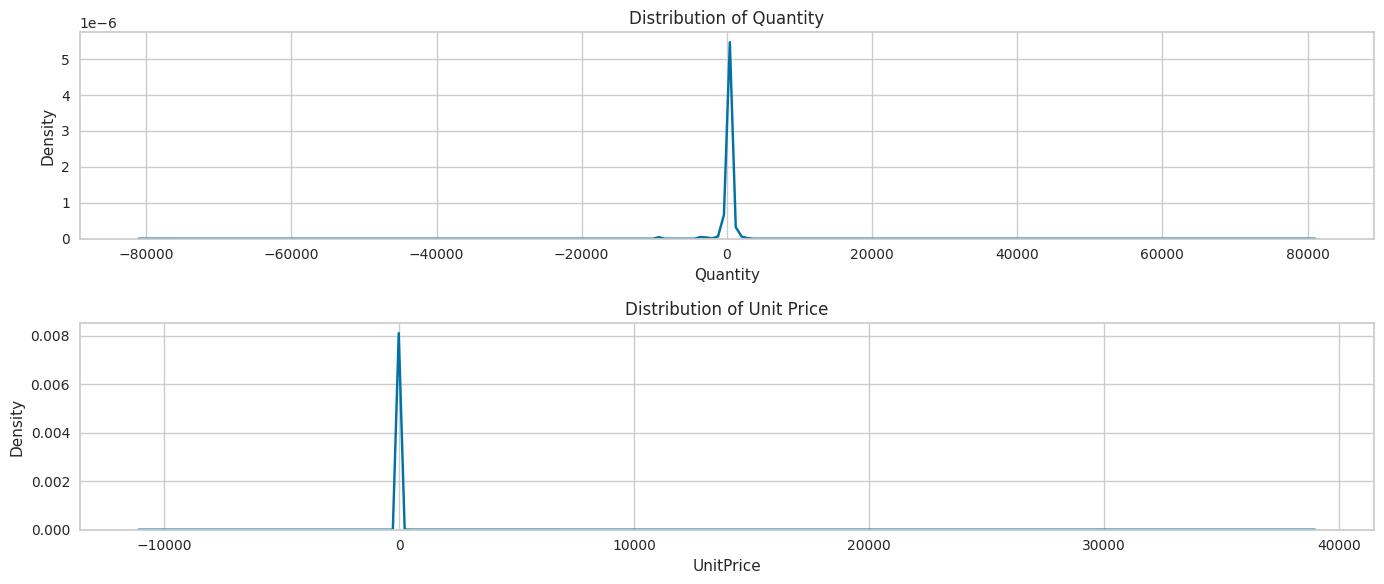

In [8]:
fig, axes = plt.subplots(2,1, figsize=(14,6))

sns.kdeplot(data=df, x='Quantity', ax=axes[0])
axes[0].set_title('Distribution of Quantity')


sns.kdeplot(data=df, x='UnitPrice', ax=axes[1])
axes[1].set_title('Distribution of Unit Price')
plt.tight_layout()

plt.savefig('plot1.png')


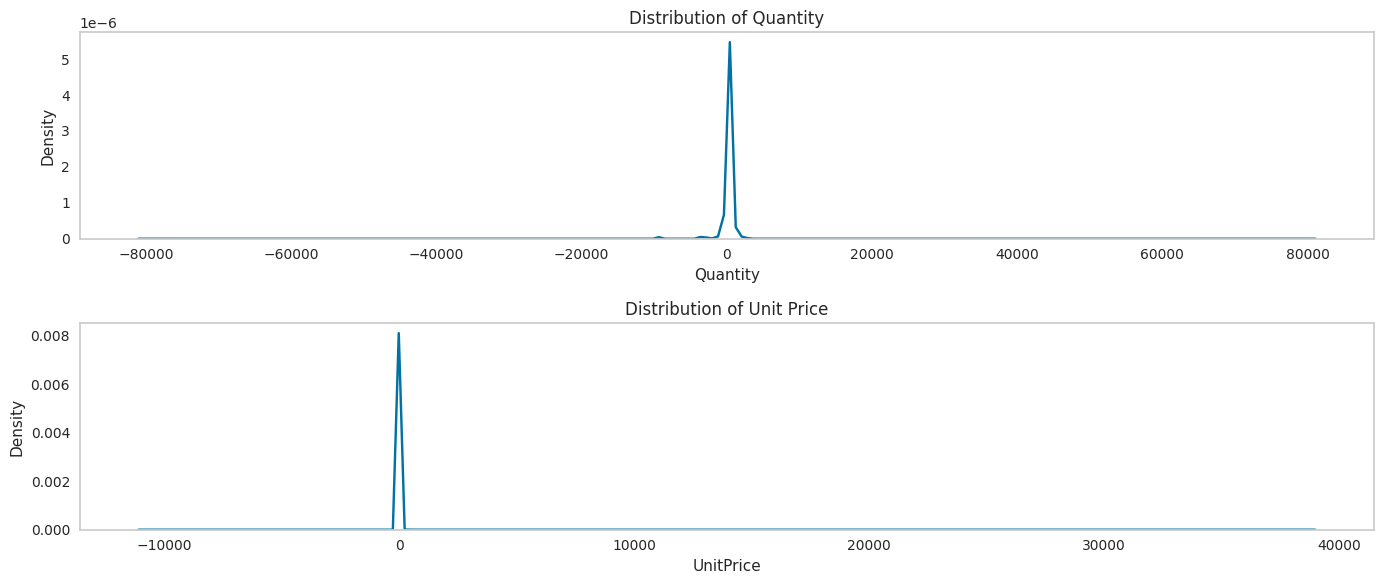

In [9]:
fig, axes = plt.subplots(2,1, figsize=(14,6))

sns.kdeplot(data=df, x='Quantity', ax=axes[0])
axes[0].set_title('Distribution of Quantity')
axes[0].grid(False)

sns.kdeplot(data=df, x='UnitPrice', ax=axes[1])
axes[1].set_title('Distribution of Unit Price')
axes[1].grid(False)
plt.tight_layout()

plt.savefig('plot1.png')

In [10]:
df.duplicated().sum()

5268

In [11]:
df['Country'].value_counts().head()

Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(f"First invoice recorded in: {df['InvoiceDate'].min()}")
print(f"Last invoice recorded in: {df['InvoiceDate'].max()}")

First invoice recorded in: 2010-12-01 08:26:00
Last invoice recorded in: 2011-12-09 12:50:00


This report analyzes customer data from December 1st, 2010, to December 9th, 2011. Key findings include:

* There are 541909 data entries
* There are 4372 unique customers recorded.
* 4223 unique products were sold.
* Orders were made from 38 different countries, with the UK having the highest share.
* 135080 invoices lack customer IDs.
* 1454 invoices have no product descriptions.
* The distribution of the quantity column spans from extremely negative values to extremely positive values.
* The distribution of the unit price column also spans from extremely negative values to extremely positive values.
* There are 5268 duplicate records.

# 2. Data Cleaning

To understand how customers typically buy (purchase behavior), I'll focus on specific information from the data. Here's what I'll use:

* Invoice details (number and date)
* Customer identification (ID)
* How much each item costs (unit price)
* How many of each item were bought (quantity)\
Before I can analyze this data, I need to clean it up. Here's what I'll do and why:
1. **Removing duplicates**. They were most likely recorded due to a system error.
2. **Subsetting columns** of interest for easier preprocessing.
3. **Removing invoices with null** customer IDs since the analysis requires known IDs.
4. **Removing invoices with negative** quantity and unit price values, as well as zero values if applicable. *Negative values refer to cancelled invoices.*
5. **Removing outliers** in both quantity and unit price columns. Having outliers usually distort the results of most analyses.
I'll use z-score to remove them.

In [13]:
#drop duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [14]:
#subsetting data
df_filtered = df[['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']].copy()

In [15]:
#drop null values
df_filtered = df_filtered.dropna()
df_filtered.isnull().sum()

InvoiceNo      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

In [16]:
df_filtered.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
dtype: object

In [17]:
positive_quantity = df_filtered['Quantity'] > 0
positive_unitprice = df_filtered['UnitPrice'] > 0

df_filtered = df_filtered[positive_quantity & positive_unitprice]

In [18]:
# The factor determines how many points to clip (the higher the value, the less points to clip and vise versa)
factor = 2
def calculate_limits(series, factor):
    q1 = np.quantile(series, 0.25)
    q3 = np.quantile(series, 0.75)
    iqr = q3 - q1
    lower_limit = q1 - iqr * factor
    upper_limit = q3 + iqr * factor
    return lower_limit, upper_limit

# Calculate limits for Quantity
lower_limit_quantity, upper_limit_quantity = calculate_limits(df_filtered['Quantity'], factor)

# Calculate limits for UnitPrice
lower_limit_unitprice, upper_limit_unitprice = calculate_limits(df_filtered['UnitPrice'], factor)

# Filter and remove outliers
df_filtered = df_filtered[
    (df_filtered['Quantity'] > lower_limit_quantity) &
    (df_filtered['Quantity'] < upper_limit_quantity) &
    (df_filtered['UnitPrice'] > lower_limit_unitprice) &
    (df_filtered['UnitPrice'] < upper_limit_unitprice)]


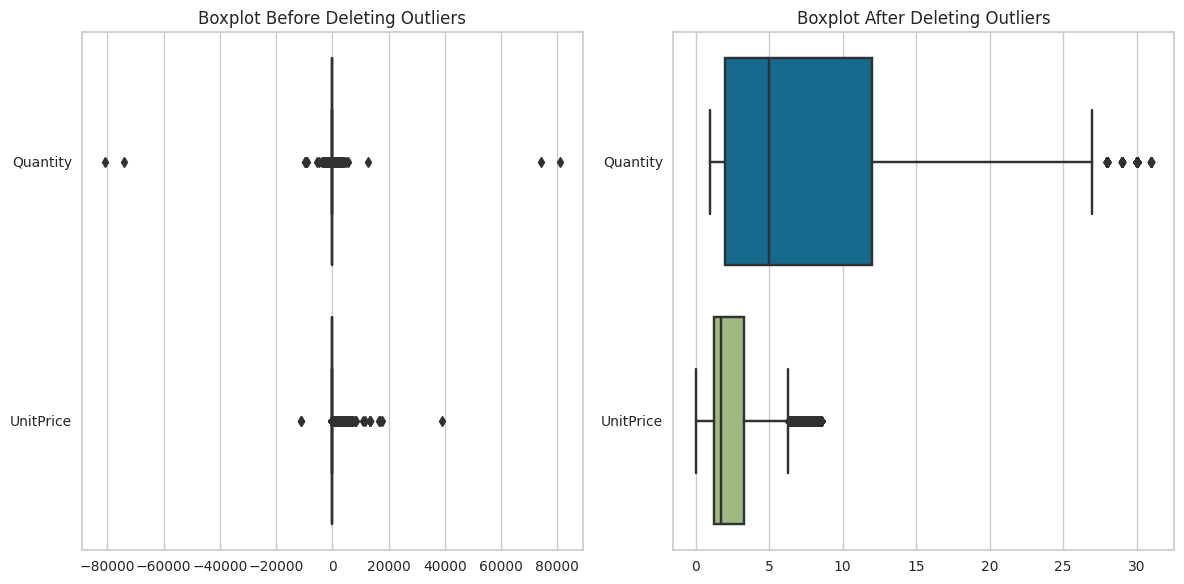

In [19]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=df, orient='h', ax=axes[0])
axes[0].set_title('Boxplot Before Deleting Outliers')

sns.boxplot(data=df_filtered, orient='h', ax=axes[1])
axes[1].set_title('Boxplot After Deleting Outliers')

plt.tight_layout()
plt.savefig('plot2.png')

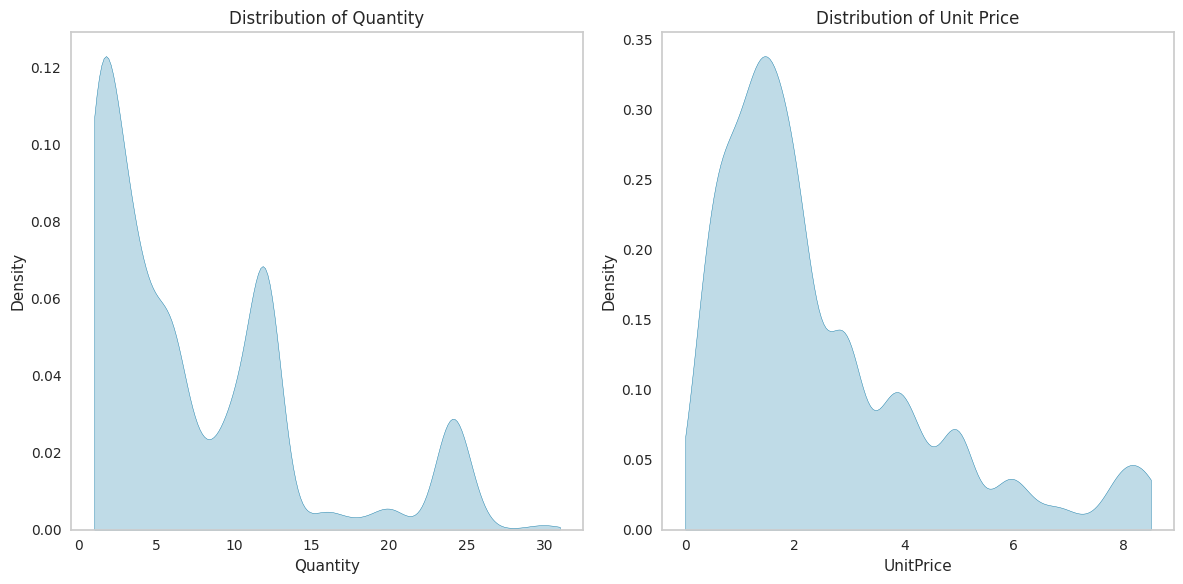

In [20]:
# Show distributions after removing outliers
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.kdeplot(data=df_filtered, x='Quantity', ax=axes[0], fill=True, cut=0, bw_adjust=2)
axes[0].set_title('Distribution of Quantity')
axes[0].grid(False)

sns.kdeplot(data=df_filtered, x='UnitPrice', ax=axes[1], fill=True, cut=0, bw_adjust=2)
axes[1].set_title('Distribution of Unit Price')
axes[1].grid(False)

plt.tight_layout()
plt.savefig('plot3.png')

# 3. Feature Engineering

The features in this dataset that tells us about customer buying behavior include Quantity, InvoiceDate, and UnitPrice.

We are going to derive a customer's RFM ( Recency, Frequency, Monetary ) value using these variables.

* **Recency**, how recently a customer made a purchase.
* **Frequency**, how many times each customer has made a purchase on the platform
* **Monetary**, calculate each user's monetary value to understand the total amount they have spent on the platform

In [21]:
df_filtered['Total Price'] = df_filtered['Quantity'] * df_filtered['UnitPrice']
df_filtered.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Total Price
0,536365,6,2010-12-01 08:26:00,2.55,17850,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850,20.34


In [22]:
latest_date = df_filtered['InvoiceDate'].max() + timedelta(1)
df_customer= df_filtered.groupby('CustomerID').agg({'InvoiceDate':lambda x:(latest_date - x.max()).days,'InvoiceNo':'nunique', 'Total Price':'sum'}).rename(columns={'InvoiceDate':'Recency','InvoiceNo': 'Frequency','Total Price': 'Monetary'})

df_customer.reset_index()

,CustomerID,Recency,Frequency,Monetary
0,12347,2,7,3450.03
1,12348,249,3,90.20
2,12349,19,1,1197.15
3,12350,310,1,294.40
4,12352,36,7,1232.44
...,...,...,...,...
4198,18280,278,1,160.70
4199,18281,181,1,46.92
4200,18282,8,2,113.13
4201,18283,4,16,2019.63


In [23]:
print(df_customer.head())
print('-----------------------------------------')
print(df_customer.describe().round(2))

            Recency  Frequency  Monetary
CustomerID                              
12347             2          7   3450.03
12348           249          3     90.20
12349            19          1   1197.15
12350           310          1    294.40
12352            36          7   1232.44
-----------------------------------------
       Recency  Frequency  Monetary
count  4203.00    4203.00   4203.00
mean     92.37       4.05   1126.72
std      99.88       7.09   2444.94
min       1.00       1.00      1.90
25%      18.00       1.00    226.33
50%      51.00       2.00    512.52
75%     143.00       4.00   1242.97
max     374.00     199.00  93958.90


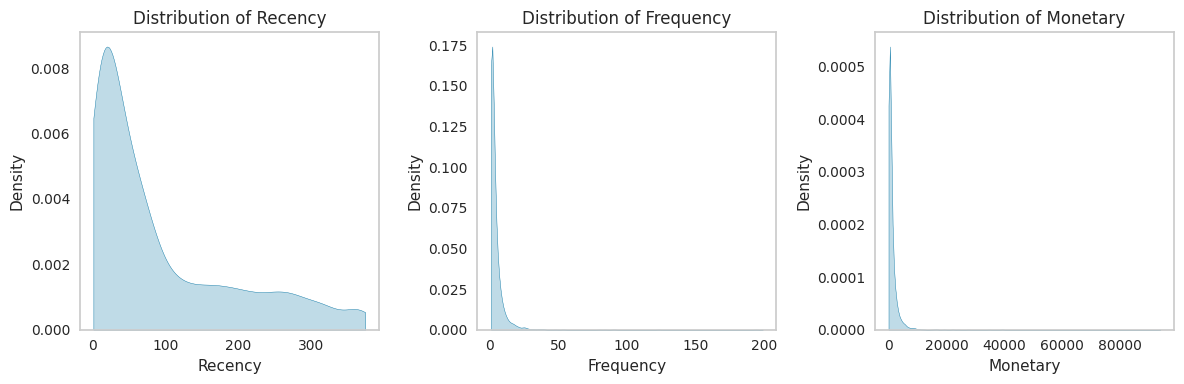

In [24]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.kdeplot(data=df_customer, x='Recency', ax=axes[0], fill=True, cut=0)
axes[0].set_title('Distribution of Recency')
axes[0].grid(False)

sns.kdeplot(data=df_customer, x='Frequency', ax=axes[1], fill=True, cut=0)
axes[1].set_title('Distribution of Frequency')
axes[1].grid(False)

sns.kdeplot(data=df_customer, x='Monetary', ax=axes[2], fill=True, cut=0)
axes[2].set_title('Distribution of Monetary')
axes[2].grid(False)

plt.tight_layout()
plt.savefig('plot4.png')

# 4. Data Preprocessing

While KMeans is a powerful tool for customer segmentation, it has some expectations about the data it works with. Here's what we need to consider:

* **Data Distribution**: KMeans works best with data that follows a bell-shaped curve (normal distribution). Our data appears skewed, so we'll need to transform it to be more like a normal distribution.
* **Feature Scaling**: KMeans relies on distances between data points. If some features have much larger values than others, it can distort the results. We'll check if our data needs scaling to ensure all features contribute equally.
* **Outliers**: Both purchase frequency and monetary value might have outliers, which can throw off some scaling methods.

**Addressing these Issues:**

To address these concerns, we'll use a technique called PowerTransformer from scikit-learn. This tool can transform the data to be closer to a normal distribution using methods like Yeo-Johnson or Box-Cox.

After applying the transformer, we'll assess whether additional scaling or outlier removal is necessary. It's important to note that transformation itself might address multiple issues at once, potentially handling skewness and scaling simultaneously.

By following these steps, we'll prepare the data for KMeans clustering, ensuring it meets the algorithm's assumptions and produces reliable customer segments.

In [25]:
transformer = PowerTransformer(method='box-cox')
transformed = transformer.fit_transform(df_customer)

In [26]:
customers_transformed = pd.DataFrame(transformed, index=df_customer.index, columns=df_customer.columns)
customers_transformed.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,-1.850830,1.197065,1.537783
12348,1.356973,0.396848,-1.397505
12349,-0.681453,-1.172298,0.659636
12350,1.576528,-1.172298,-0.471611
12352,-0.256979,1.197065,0.683454


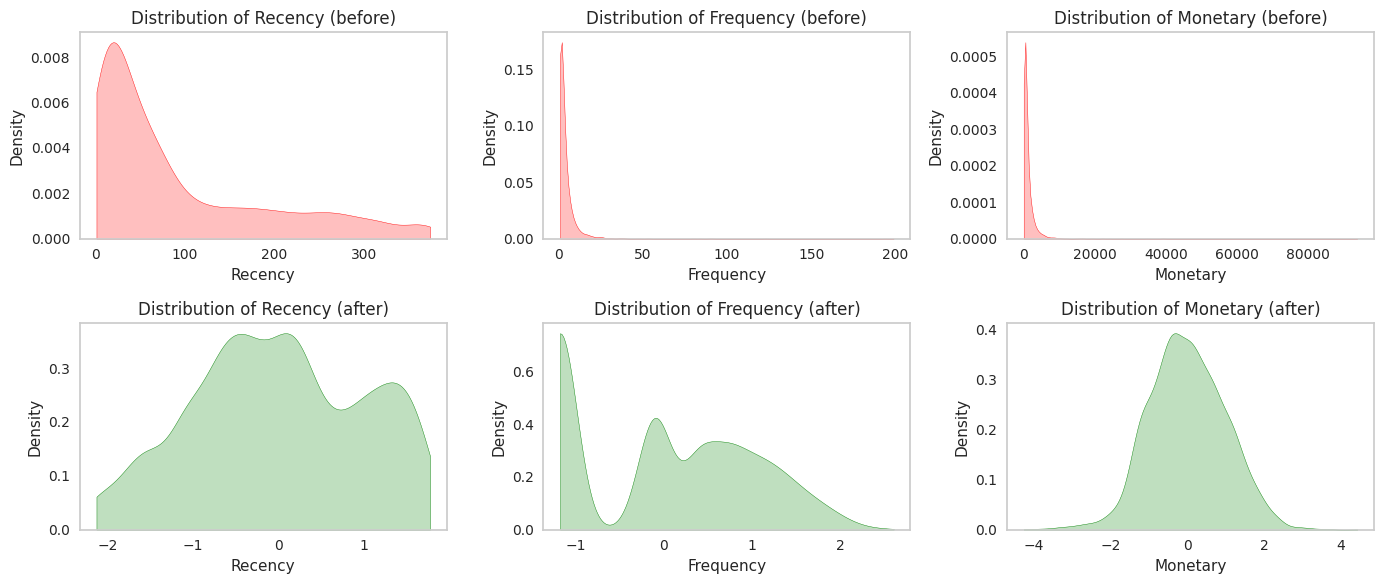

In [27]:
fig, axes = plt.subplots(2,3, figsize=(14,6))

sns.kdeplot(data=df_customer, x='Recency', ax=axes[0,0], fill=True, cut=0, color='red')
axes[0,0].set_title('Distribution of Recency (before)')
axes[0,0].grid(False)
sns.kdeplot(data=df_customer, x='Frequency', ax=axes[0,1], fill=True, cut=0, color='red')
axes[0,1].set_title('Distribution of Frequency (before)')
axes[0,1].grid(False)
sns.kdeplot(data=df_customer, x='Monetary', ax=axes[0,2], fill=True, cut=0, color='red')
axes[0,2].grid(False)
axes[0,2].set_title('Distribution of Monetary (before)')

sns.kdeplot(data=customers_transformed, x='Recency', ax=axes[1,0], fill=True, cut=0, color='green')
axes[1,0].set_title('Distribution of Recency (after)')
axes[1,0].grid(False)
sns.kdeplot(data=customers_transformed, x='Frequency', ax=axes[1,1], fill=True, cut=0, color='green')
axes[1,1].set_title('Distribution of Frequency (after)')
axes[1,1].grid(False)
sns.kdeplot(data=customers_transformed, x='Monetary', ax=axes[1,2], fill=True, cut=0, color='green')
axes[1,2].set_title('Distribution of Monetary (after)')
axes[1,2].grid(False)

plt.tight_layout()
plt.savefig('plot5.png')

# 5. K-Means Clustering

Now, I'll use elbow-method to find the optimal number of clusters for the data.

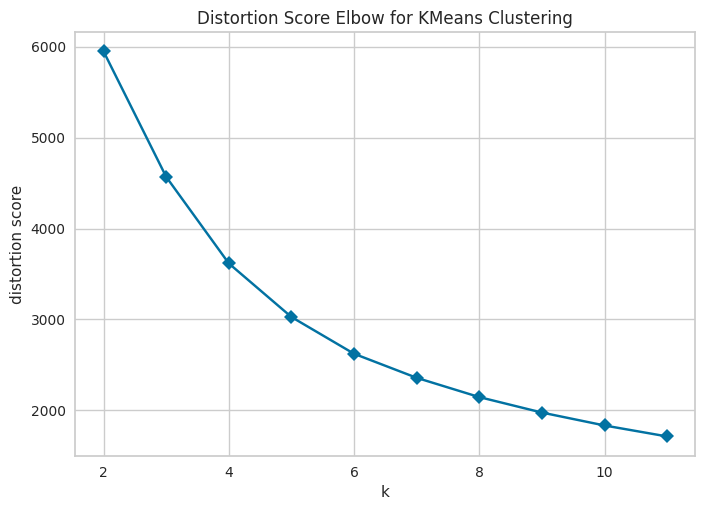

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, locate_elbow=False)
visualizer.fit(customers_transformed)  
visualizer.show()

In [29]:
kmeans = KMeans(n_clusters=4, random_state=0)

In [30]:
df_customer['Cluster'] = kmeans.fit_predict(customers_transformed)
df_customer.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347,2,7,3450.03,1
12348,249,3,90.20,0
12349,19,1,1197.15,3
12350,310,1,294.40,0
12352,36,7,1232.44,1


In [31]:
df_customer.groupby('Cluster').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean','count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        234.88      1.19   236.28  1021
1         14.28     10.06  3051.93  1025
2         78.94      3.40   887.23  1263
3         38.10      1.33   274.69   894

In [32]:
cluster_mapping = {0:'Zero',
                   1:'One',
                   2:'Two',
                   3:'Three'}

df_customer['Cluster'] = df_customer['Cluster'].map(cluster_mapping)
df_customer.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347,2,7,3450.03,One
12348,249,3,90.20,Zero
12349,19,1,1197.15,Three
12350,310,1,294.40,Zero
12352,36,7,1232.44,One


In [33]:
customers_transformed['Cluster'] = df_customer['Cluster']

customers_melt = pd.melt(customers_transformed.reset_index(),
                         id_vars=['CustomerID', 'Cluster'],
                         value_vars=['Recency', 'Frequency', 'Monetary'],
                         var_name='Attribute',
                         value_name='Value')

customers_melt.head()

,CustomerID,Cluster,Attribute,Value
0,12347,One,Recency,-1.850830
1,12348,Zero,Recency,1.356973
2,12349,Three,Recency,-0.681453
3,12350,Zero,Recency,1.576528
4,12352,One,Recency,-0.256979


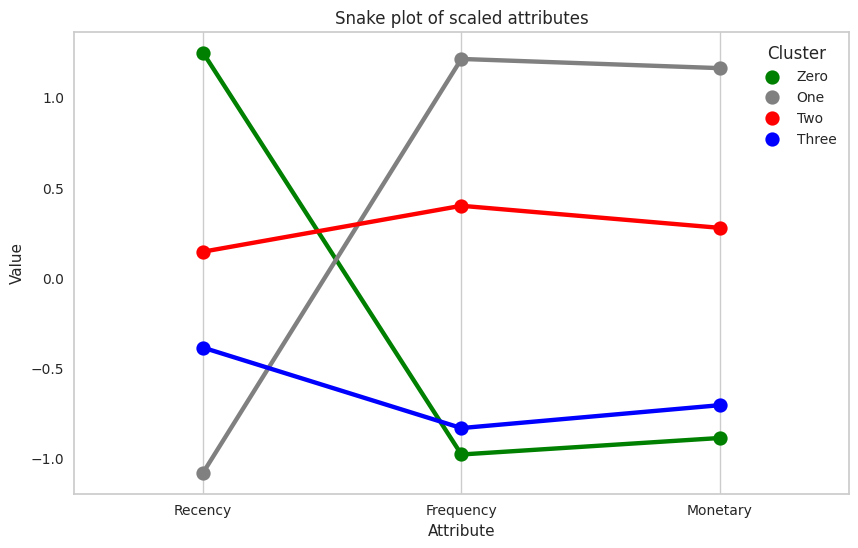

In [34]:
figure = plt.figure(figsize=(10,6))

palette = {'Zero': 'green', 'One': 'grey', 'Two': 'red', 'Three': 'blue'}

sns.pointplot(x='Attribute', y='Value', hue='Cluster', data=customers_melt, errorbar=None, hue_order=['Zero','One','Two', 'Three'], palette=palette)

plt.grid(axis='both')
plt.title('Snake plot of scaled attributes')
plt.savefig('plot6.png')

Change the cluster name
* Zero to Bronze
* One to Platinum
* Two to Gold
* Three to Silver

In [35]:
cluster_mapping = {'Zero':'Bronze',
                   'One':'Platinum',
                   'Two':'Gold',
                   'Three':'Silver'}

df_customer['Cluster'] = df_customer['Cluster'].map(cluster_mapping)
df_customer.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347,2,7,3450.03,Platinum
12348,249,3,90.20,Bronze
12349,19,1,1197.15,Silver
12350,310,1,294.40,Bronze
12352,36,7,1232.44,Platinum


In [36]:
customers_transformed['Cluster'] = df_customer['Cluster']

customers_melt = pd.melt(customers_transformed.reset_index(),
                         id_vars=['CustomerID', 'Cluster'],
                         value_vars=['Recency', 'Frequency', 'Monetary'],
                         var_name='Attribute',
                         value_name='Value')

customers_melt.head()

,CustomerID,Cluster,Attribute,Value
0,12347,Platinum,Recency,-1.850830
1,12348,Bronze,Recency,1.356973
2,12349,Silver,Recency,-0.681453
3,12350,Bronze,Recency,1.576528
4,12352,Platinum,Recency,-0.256979


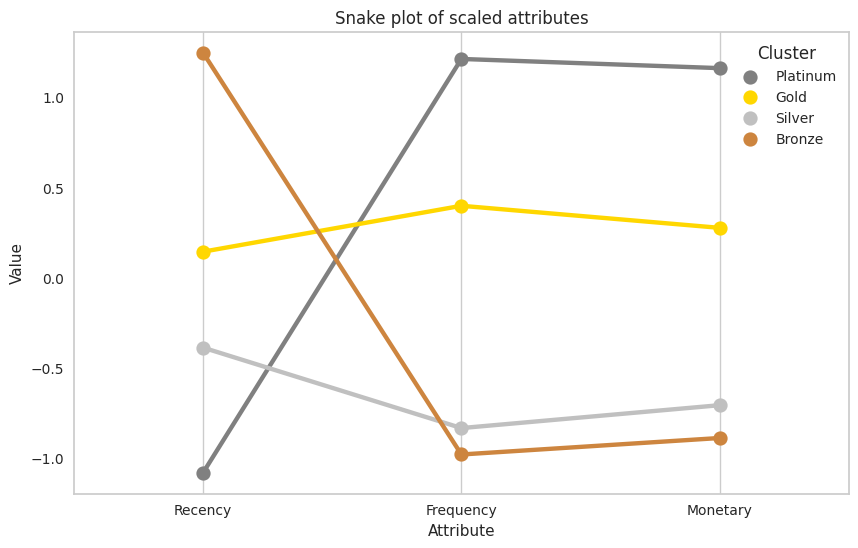

In [37]:
figure = plt.figure(figsize=(10,6))

palette = {'Platinum':'gray', 'Gold':'gold', 'Silver':'silver', 'Bronze':'peru'}

sns.pointplot(x='Attribute', y='Value', hue='Cluster', data=customers_melt, errorbar=None, hue_order=['Platinum', 'Gold', 'Silver', 'Bronze'], palette=palette)

plt.grid(axis='both')
plt.title('Snake plot of scaled attributes')
plt.savefig('plot7.png')